In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

import os

if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"

In [2]:
#with open(f'complete_pooling_metrics.pkl', 'rb') as f:
#    complete_pooling_metrics = pickle.load(f)

with open(f'complete_pooling_trials_metrics.pkl', 'rb') as f:
    complete_pooling_trials_metrics = pickle.load(f)

with open(f'complete_pooling_subjects_metrics.pkl', 'rb') as f:
    complete_pooling_subjects_metrics = pickle.load(f)

with open(f'partial_pooling_global_metrics.pkl', 'rb') as f:
    partial_pooling_global_metrics = pickle.load(f)

with open(f'partial_pooling_local_metrics.pkl', 'rb') as f:
    partial_pooling_local_metrics = pickle.load(f)

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [3]:
partial_pooling_local_metrics

{'NRMSE': VariableArray([0.02181255, 0.03507674, 0.00649336, 0.04822643, 0.01445076]),
 'NRMSE-mad': array([0.00022891, 0.00058916, 0.00068311, 0.00055959, 0.00015339]),
 'calibration_error': VariableArray([0.07020175, 0.0345614 , 0.01604386, 0.0345614 , 0.01604386]),
 'calibration_error-mad': array([0.01982456, 0.01740351, 0.00649123, 0.01740351, 0.00649123])}

In [4]:
pretty_param_names = [r'$\nu^{(r)}$', r'$\alpha^{(r)}$', r'$t_{0}^{(r)}$', r'$\beta^{(r)}$']
n_params = len(pretty_param_names)

pooling_models = [
    'No-Pooling',  # trials
    'Complete Pooling',  # subjects
    'Partial Pooling' # local values
]
colors = [
    "#E7298A",  # magenta pink
    "#7570B3",  # muted purple
    "#1B9E77",  # teal green
    "#D95F02",  # deep orange
]
fontsize = 11

metrics_names = list(complete_pooling_subjects_metrics.keys())
metrics_names_pretty = [r'NRMSE', "", r'Calibration Error']

In [5]:
model_budget = [
    complete_pooling_trials_metrics,
    complete_pooling_subjects_metrics,
    partial_pooling_local_metrics,
]

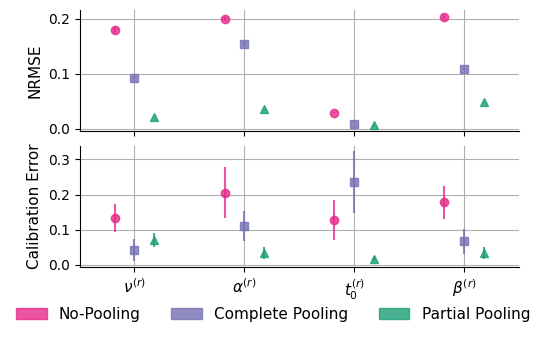

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5, 3), layout='constrained')

metrics_rows = [0, 2]  # which metrics to plot, one per row
model_metrics = [
    complete_pooling_trials_metrics,
    complete_pooling_subjects_metrics,
    partial_pooling_local_metrics,
]
markers = ['o', 's', '^']  # one per pooling model
group_x = np.arange(n_params)
width = 0.18
offsets = np.linspace(-width, width, len(model_metrics))

for r, mi in enumerate(metrics_rows):
    ax = axes[r]
    metric = metrics_names[mi]

    for k in range(len(model_metrics)):
        vals = [model_metrics[k][metric][j] for j in range(n_params)]
        yerrs = [model_metrics[k][metric + '-mad'][j] for j in range(n_params)]
        ax.errorbar(
            group_x + offsets[k],
            vals,
            yerr=yerrs,
            fmt=markers[k],
            linestyle='',
            alpha=0.8,
            color=colors[k],
            label=pooling_models[k] if r == 0 else None,
        )

    ax.set_xlim(-0.5, n_params - 0.5)
    #ax.set_ylim(0, 0.4)
    ax.set_xticks(group_x, pretty_param_names, fontsize=fontsize)
    ax.set_ylabel(metrics_names_pretty[mi], fontsize=fontsize)
    ax.grid(True)

for a in axes:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

handles = [
    Patch(color=colors[i], label=pooling_models[i], alpha=0.8) for i in range(len(pooling_models))
]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.1),
           ncols=len(model_metrics), fontsize=fontsize, frameon=False)
plt.savefig('plots/pooling_metrics.pdf', bbox_inches='tight')
plt.show()

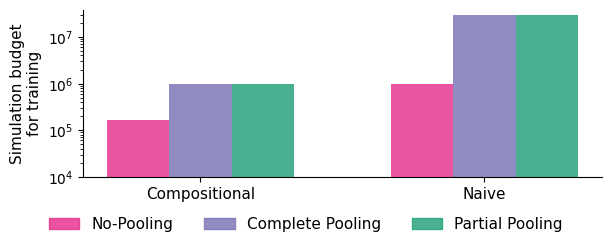

In [7]:
# Simulation budget dictionary
training_sets = 128 * 256
validation_sets = 1 # 300
few_trials = 5
simulation_budget = {
    "No-Pooling": {
        "Single_training_instance": few_trials * training_sets,
        "Single_training_instance_naive": 30 * training_sets,
        "Inference_budget": 30*validation_sets,
    },
    "Complete Pooling": {
        "Single_training_instance": 30 * training_sets,
        "Single_training_instance_naive": 30*30 * training_sets,
        "Inference_budget": 30*30*validation_sets,
    },
    "Partial Pooling": {
        "Single_training_instance": 30 * training_sets,
        "Single_training_instance_naive": 30*30 * training_sets,
        "Inference_budget": 30*30*validation_sets,
    },
}

categories = ["Single_training_instance", "Single_training_instance_naive"] # , "Inference_budget"]
labels = ["Compositional", "Naive", "Inference\nbudget"][:len(categories)]
x = np.arange(len(categories))
width = 0.22

fig, ax = plt.subplots(figsize=(6, 2), layout="constrained")

for i, model in enumerate(pooling_models):
    values = [simulation_budget[model][cat] for cat in categories]
    ax.bar(x + (i - 1)*width, values, width, label=model, color=colors[i], alpha=0.8)

ax.set_xticks(x, labels, fontsize=fontsize)
ax.set_ylabel("Simulation budget\nfor training", fontsize=fontsize)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_yscale("log")
ax.set_ylim(bottom=1e4)

handles = [
    Patch(color=colors[i], label=pooling_models[i], alpha=0.8) for i in range(len(pooling_models))
]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.2),
           ncols=len(pooling_models), fontsize=fontsize, frameon=False)

#plt.savefig("plots/pooling_simulation_budget.pdf", bbox_inches="tight")
plt.show()

# Model Visualization

In [ ]:
def simulate_ddm_path(nu, alpha, t0, beta, dt=1e-3, scale=1.0, max_time=3.0):
    y = beta * alpha
    rt = 0.0
    const = scale * np.sqrt(dt)
    ys = [y]
    ts = [0.0]
    while (alpha >= y >= 0) and rt <= max_time:
        z = np.random.randn()
        y += nu * dt + const * z
        rt += dt
        ys.append(y)
        ts.append(rt)
    c = 1.0 if y >= alpha else 0.0
    return np.array(ts) + t0, np.array(ys), c


# Parameters
np.random.seed(11)
alpha = 1.2
beta = 0.55
t0 = 0.6
dt = 1e-3
max_t = 2
x_label = 0.05*1000
colors = ["#5DADE2", "#76D7C4", "#9B59B6"]



# Re create the sample path figures
for nu in [0.2]:
    plt.figure(figsize=(6,4), layout='constrained')
    for i in range(3):
        ts, ys, c = simulate_ddm_path(nu=nu, alpha=alpha, t0=t0, beta=beta, dt=dt, max_time=max_t)
        plt.plot(ts*1000, ys, linewidth=1.0, color=colors[i])
    plt.axhline(0.0, linestyle="--", linewidth=1.0, color='black')
    plt.axhline(alpha, linestyle="--", linewidth=1.0, color='black')
    plt.axhline(beta*alpha, linestyle="--", linewidth=1.0, color='black')
    plt.hlines(alpha*0.5, xmin=x_label*0.1, xmax=t0*1000, linewidth=1.0, color='black')

    # deterministic drift line
    t_det = np.linspace(0, max_t, 500)
    y_det = beta * alpha + nu * t_det
    plt.plot((t_det + t0)*1000, y_det, color="black", linestyle="-", linewidth=1.0)

    #plt.title(f"DDM sample paths at drift rate nu = {nu}")
    plt.text(x_label, beta*alpha, r"$\beta\alpha$", va="bottom", ha="left", fontsize=fontsize)
    plt.text(x_label, alpha, r"upper decision threshold $\alpha$", va="bottom", ha="left", fontsize=fontsize)
    plt.text(x_label, 0, r"lower decision threshold", va="top", ha="left", fontsize=fontsize)
    plt.text(x_label, alpha*0.5, r"non-decision time $t_0$", va="top", ha="left", fontsize=fontsize)
    plt.text(t0*1000+400, beta*alpha+0.22, r"drift rate $\nu$", va="top", ha="left", rotation=12, fontsize=fontsize)
    plt.xlim(0, max_t*1000)
    plt.xticks(np.linspace(0, max_t*1000, 8), "")
    plt.yticks(np.linspace(0, alpha, 7), "")
    plt.xlabel(r"Time [ms]", fontsize=fontsize)
    plt.ylabel(r"Evidence $y$", fontsize=fontsize)
    plt.savefig('plots/model_visualization_ddm.pdf', bbox_inches='tight')
    plt.show()